# Gaussianization from Scratch

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(root))

%load_ext autoreload
%autoreload 2

## Import Packages

In [2]:
import numpy as np

from sklearn.datasets import make_moons

# Packages
import numpy as np
from sklearn.decomposition import PCA
from picard import Picard
import pytorch_lightning as pl


# Plot
import matplotlib.pyplot as plt
import corner

import wandb
pl.seed_everything(1234)

%load_ext autoreload
%autoreload 2

Global seed set to 1234


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Logging

In [3]:
# TODO

## Data

In [76]:
ntrain = 100_000
ntest = 10_000
noise = 0.1
random_state = 123
train_data = make_moons(n_samples=ntrain, noise=noise, random_state=random_state)[0]
test_data = make_moons(n_samples=ntest, noise=noise, random_state=random_state*10)[0]

### Plot Data

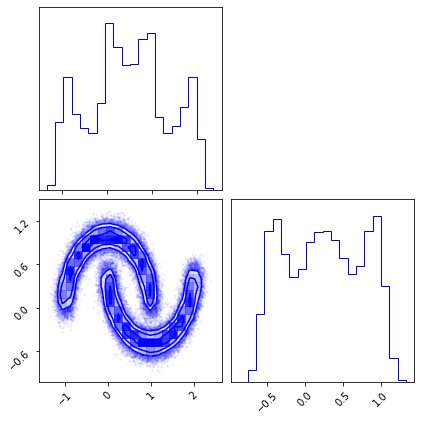

In [77]:
fig = plt.figure(figsize=(7, 7))

corner.corner(train_data, color="blue", fig=fig)

plt.show()

## Flow Transformation

In [78]:
class Bijector:
    
    def forward(self, X):
        raise NotImplemented
        
    def inverse(self, X):
        raise NotImplemented
    
    def gradient(self, X):
        raise NotImplemented
    

## Univariate Gaussianization

### Uniformization

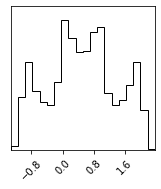

In [7]:
X_1 = train_data[:, 0]
X_2 = train_data[:, 1]

fig = corner.corner(X_1)

In [42]:
from typing import NamedTuple, Callable, Union
from scipy import stats


class UnivariateHistogram:
    def __init__(self, X: np.ndarray, bins: Union[int,str]=10, alpha: float=1e-10, bound_ext: float=0.1):
        
        diff = X.max() - X.min()
        lower_bound = X.min() - bound_ext * diff
        upper_bound = X.max() + bound_ext * diff

        # create histogram 
        hist = np.histogram(X, bins=bins, range=(lower_bound, upper_bound))

        # create histogram object
        estimator = stats.rv_histogram(hist)

        # add some regularization
        estimator._hpdf += alpha
        
        self.estimator = estimator
        
    def forward(self, X):
        
        return self.estimator.cdf(X)
    
    def inverse(self, X):
        
        return self.estimator.ppf(X)
    
    def gradient(self, X):
        
        return self.estimator.pdf(X)

In [43]:
hist_uni_bijector = UnivariateHistogram(X_1, bins="scott")

#### Forward Transformation

In [14]:
Xu_1 = hist_uni_bijector.forward(X_1)

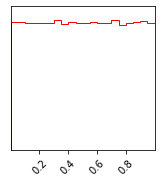

In [15]:
fig = corner.corner(Xu_1, color="red")

#### Inverse Transformation

In [16]:
X_1_approx = hist_uni_bijector.inverse(Xu_1)

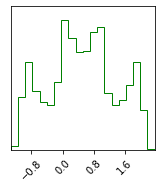

In [17]:
fig = corner.corner(X_1_approx, color="green")

#### Det Jacobian

In [18]:
Xldj_1 = hist_uni_bijector.gradient(X_1)

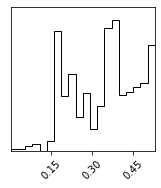

In [19]:
fig = corner.corner(Xldj_1)

### Density Estimation

In [20]:
base_dist = stats.uniform()

In [21]:
# latent probability
pz = base_dist.pdf(Xu_1)

# det jacobian
det_jacobian = hist_uni_bijector.gradient(X_1)

# total prob
p_x = pz * det_jacobian

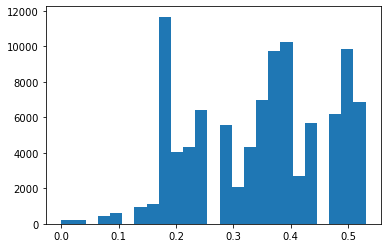

In [22]:
fig, ax = plt.subplots()
ax.hist(p_x, bins=25)
plt.show()

### Sampling

In [23]:
# generate samples in uniform domain
pz_samples = base_dist.rvs(size=10_000)

# propagate them through
X_1_samples = hist_uni_bijector.inverse(pz_samples)

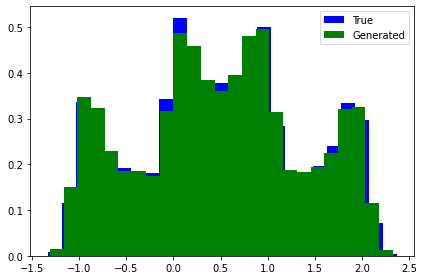

In [24]:
fig, ax = plt.subplots()
ax.hist(X_1, bins=25, color='blue', density=True, label="True")
ax.hist(X_1_samples, bins=25, color='green', density=True, label="Generated")
plt.legend()
plt.tight_layout()
plt.show()

### Inverse CDF

In [30]:
class InverseGaussCDF:
    def __init__(self, eps: float=1e-5):
        self.eps = eps
        
        # create histogram object
        self.estimator = stats.norm(loc=0, scale=1)
    
    def forward(self, X):
        
        X = np.clip(X, self.eps, 1-self.eps)
        
        Z = self.estimator.ppf(X)
        
        return Z
        
    def inverse(self, Z):
        X = self.estimator.cdf(Z)
        
        return X
    
    def gradient(self, X):
        X = self.inverse(X)
        
        det_jacobian = - self.estimator.pdf(X)
        
        return det_jacobian


def inverse_cdf(eps: float=1e-5):
    
    
    
    def forward(X):
        

        
        return X
    
    def inverse(X):
        
        
        
        
        return X
    
    def gradient(X):
        
        
        
        
        
        return X
    
    
    return Bijector(
        forward=forward, 
        inverse=inverse, 
        gradient=gradient
    )

In [31]:
invcdf_bijector = InverseGaussCDF(eps=1e-7)

#### Forward

In [32]:
Xg_1 = invcdf_bijector.forward(Xu_1)

#### Inverse

In [33]:
Xu_1_approx = invcdf_bijector.inverse(Xg_1)

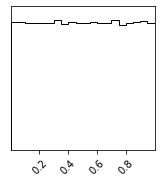

In [34]:
fig = corner.corner(Xu_1_approx)

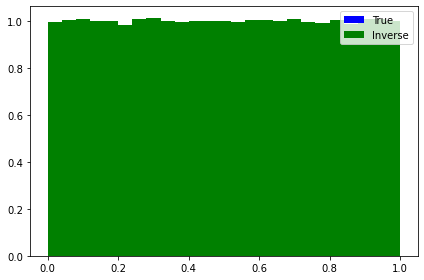

In [35]:
fig, ax = plt.subplots()
ax.hist(Xu_1, bins=25, color='blue', density=True, label="True")
ax.hist(Xu_1_approx, bins=25, color='green', density=True, label="Inverse")
plt.legend()
plt.tight_layout()
plt.show()

#### Gradient

In [36]:
Xg_1_gradient = invcdf_bijector.gradient(Xu_1)

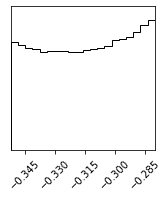

In [37]:
fig = corner.corner(Xg_1_gradient)

#### Density Estimation

In [38]:
# 1) uniformization
Xu_1 = hist_uni_bijector.forward(X_1)
det_jacobian_u = hist_uni_bijector.gradient(X_1)

# 2) gaussianization
Xg_1 = hist_uni_bijector.forward(Xu_1)
det_jacobian_g = hist_uni_bijector.gradient(Xu_1)

# latent probability
base_dist = stats.norm(loc=0, scale=1)

pz = base_dist.pdf(Xg_1)



# total prob
p_x = pz * det_jacobian_g * det_jacobian_u

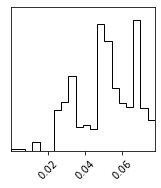

In [39]:
fig = corner.corner(p_x)

#### Sampling

In [40]:
# 1) samples from latent probability
base_dist = stats.norm(loc=0, scale=1)
pz_samples = base_dist.rvs(size=10_000)

# 2) inverse gaussianization
Xu_1_samples = hist_uni_bijector.inverse(pz_samples)

# 3) inverse uniformization
X_1_samples = hist_uni_bijector.inverse(Xu_1_samples)

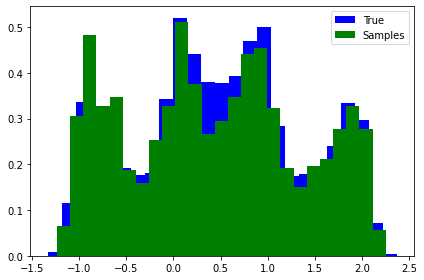

In [41]:
fig, ax = plt.subplots()
ax.hist(X_1, bins=25, color='blue', density=True, label="True")
ax.hist(X_1_samples, bins=25, color='green', density=True, label="Samples")
plt.legend()
plt.tight_layout()
plt.show()

### Marginal Gaussianization

#### Marginal Uniformization

In [79]:
class MarginalHistogramUniformization:
    def __init__(self, X: np.ndarray, bins: Union[int,str]=10, alpha: float=1e-10, bound_ext: float=0.1):
        
        estimators = []
        
        
        for iX in X.T:
            diff = iX.max() - iX.min()
            lower_bound = iX.min() - bound_ext * diff
            upper_bound = iX.max() + bound_ext * diff

            # create histogram 
            hist = np.histogram(iX, bins=bins, range=(lower_bound, upper_bound))

            # create histogram object
            i_estimator = stats.rv_histogram(hist)

            # add some regularization
            i_estimator._hpdf += alpha
            
            estimators.append(i_estimator)
            
        self.estimators = estimators
        
    def forward(self, X):
        
        Z = np.zeros_like(X)
        for idim, iX in enumerate(X.T):
            Z[:, idim] = self.estimators[idim].cdf(iX)
        
        return Z
    
    def inverse(self, Z):
        
        X = np.zeros_like(Z)
        
        for idim, iZ in enumerate(Z.T):
            
            X[:, idim] = self.estimators[idim].ppf(iZ)
        
        return X
    
    def gradient(self, X):
        
        X_grad = np.zeros_like(X)
        
        for idim, iX in enumerate(X.T):
            X_grad[:, idim] = self.estimators[idim].pdf(iX)
        
        return X_grad

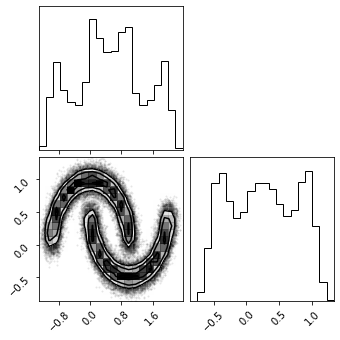

In [80]:
fig = corner.corner(train_data)

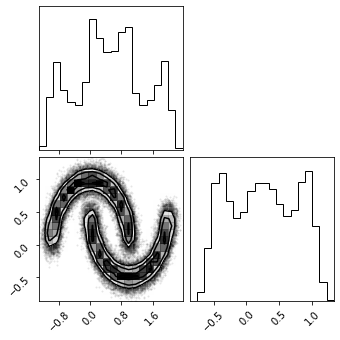

In [81]:
marg_hist_bijector = MarginalHistogramUniformization(X=train_data)
fig = corner.corner(train_data)


In [82]:
X_u = marg_hist_bijector.forward(train_data)

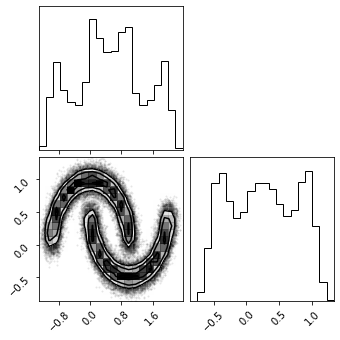

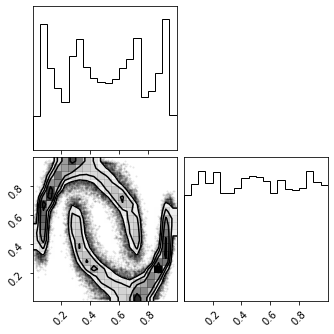

In [83]:
fig = corner.corner(train_data)
fig = corner.corner(X_u)

In [84]:
X_approx = marg_hist_bijector.inverse(X_u)

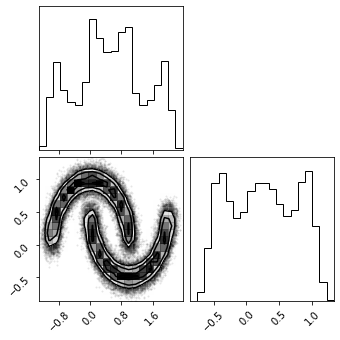

In [85]:
fig = corner.corner(X_approx)

In [211]:
def marginal_transformation(ndims: int, f, **kwargs):
    
    # loop through the dimensions
    transformations = []
    for _ in range(ndims):
        
        try:
            marg_f = f(**kwargs)
        except:
            marg_f = f(**kwargs)
    
        transformations.append(marg_f)
        
    def forward(X):
        
        for idim, iX, ifunc in zip(enumerate(X.T, transformations)):
            X[:, idim] = ifunc.forward(iX)
            
        return X
    
    def inverse(X):
        
        for idim, iX, ifunc in zip(enumerate(X.T, transformations)):
            X[:, idim] = ifunc.inverse(iX)
            
        return X
    
    def gradient(X):
        
        for idim, iX, ifunc in zip(enumerate(X.T, transformations)):
            X[:, idim] = ifunc.gradient(iX)
            
        return X
    
    return Bijector(
        forward=forward, 
        inverse=inverse, 
        gradient=gradient
    )

In [213]:
marginal_uniformize = marginal_transformation(marginal_histogram, X=train_data)

NameError: name 'X' is not defined

### Rotation

## 